# Evaluation of the model

The goal is to compare the generated 3d model with the groud truth.

In [1]:
from os.path import join, exists, abspath, dirname
from os import makedirs
import logging
import sys, os

sys.path.append(os.path.expanduser('/home/ubuntu/pynb/project/smpl/'))
import cPickle as pickle
from time import time
from glob import glob
import argparse

import cv2
import numpy as np
import chumpy as ch

from opendr.camera import ProjectPoints
from lib.robustifiers import GMOf
from smpl_webuser.serialization import load_model
from smpl_webuser.lbs import global_rigid_transformation
from smpl_webuser.verts import verts_decorated
from lib.sphere_collisions import SphereCollisions
from lib.max_mixture_prior import MaxMixtureCompletePrior
from render_model import render_model
from fit_3d_new import *
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from os import makedirs
import numpy.linalg as LA
import os.path as OP
%matplotlib inline
##

###  To Test on one frame

In [41]:
_LOGGER = logging.getLogger(__name__) 
input_arg = '../../db/manipulation_videos/barbell_0002/'
list_img = sorted(glob(join(input_arg+'frames/', '*[0-9].jpg')))
path_joint = input_arg+'joint/'
output = input_arg+"3d/continue/"
# Set up paths & load models.
# Assumes 'models' in the 'code/' directory where this file is in.
MODEL_DIR = join('/home/ubuntu/pynb/project/smplify_public/code', 'models')
# Model paths:
MODEL_NEUTRAL_PATH = join(
    MODEL_DIR, 'basicModel_neutral_lbs_10_207_0_v1.0.0.pkl')
MODEL_FEMALE_PATH = join(
    MODEL_DIR, 'basicModel_f_lbs_10_207_0_v1.0.0.pkl')
MODEL_MALE_PATH = join(MODEL_DIR,
                       'basicmodel_m_lbs_10_207_0_v1.0.0.pkl')

    # paths to the npz files storing the regressors for capsules
SPH_REGS_NEUTRAL_PATH = join(MODEL_DIR,
                             'regressors_locked_normalized_hybrid.npz')
SPH_REGS_FEMALE_PATH = join(MODEL_DIR,
                            'regressors_locked_normalized_female.npz')
SPH_REGS_MALE_PATH = join(MODEL_DIR,
                          'regressors_locked_normalized_male.npz')

# parameter of the main
n_betas=10
flength=5000.
pix_thsh=25.
viz=False
num = 89


do_degrees=[0.]
gender='male'
model = load_model(MODEL_MALE_PATH)
sph_regs = np.load(SPH_REGS_MALE_PATH)
# First we do estimation for one frame
est = np.load(join(path_joint, str(num)+'.npz'))['arr_0']
img = cv2.imread(list_img[num])
joints = est[:2, :].T
conf = est[2, :]
# 
t0 = time()
params, vis, cam,try_both_orient, orient = run_single_fit(
                    img,
                    joints,
                    conf,
                    model,
                regs=sph_regs,
                n_betas=n_betas,
                flength=flength,
                pix_thsh=pix_thsh,
                scale_factor=2,
                viz=viz,
                do_degrees=do_degrees)

print(time()-t0)


(70,)
(70,)
(70,)
(70,)
1133.28360295


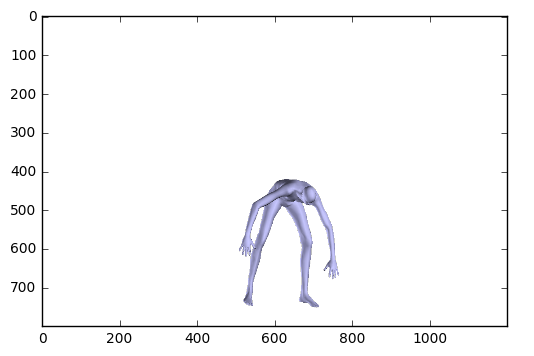

In [35]:
plt.imshow(vis[0])
#plt.imsave('../../db/error_fixing_shape.png', vis[0])

In [11]:
import sys
import os.path as OP
from os import makedirs
import cPickle as pickle
from glob import glob
import argparse
import numpy as np
import numpy.linalg as LA
import chumpy as ch
from smpl_webuser.serialization import load_model
from smpl_webuser.lbs import global_rigid_transformation
import xml.etree.ElementTree as ET

def procrustes(A, B):
    '''
    Solves the orthogonal Procrustes problem given a set of 3D points A (3 x N)
    and a set of target 3D points B (3 x N). Namely, it computes a group of
    R(otation), t(ranslation) and s(cale) that aligns A with B.
    '''
    # input check
    transposed = False
    if A.shape[0]!=3:
        A = A.T
        B = B.T
        transposed = True
    N = A.shape[1]
    assert(B.shape==(3,N))
    # compute mean
    a_bar = A.mean(axis=1, keepdims=True)
    b_bar = B.mean(axis=1, keepdims=True)
    # calculate rotation
    A_c = A - a_bar
    B_c = B - b_bar
    M = A_c.dot(B_c.T)
    U, Sigma, Vh = LA.svd(M)
    V = Vh.T
    Z = np.eye(U.shape[0])
    Z[-1,-1] = LA.det(V)*LA.det(U)
    R = V.dot(Z.dot(U.T))
    # compute scale
    s = np.trace(R.dot(M)) / np.trace(A_c.T.dot(A_c))
    # compute translation
    t = b_bar - s*(R.dot(a_bar))
    # compute A after alignment
    A_hat = s*(R.dot(A)) + t
    if transposed:
        A_hat = A_hat.T
    return (R, t, s, A_hat)

def compute_euclidean_dist(S1,S2,debug=False):
    #print S1.shape, S2.shape
    assert(S2.shape == S1.shape)
    assert(S1.shape[1] == 3) # S1 and S2 should be of shape njoints x 3
    distance = 0.
    for i in range(S1.shape[0]):
        distance += LA.norm(S1[i]-S2[i])
        if debug:
            print 'joint #{0}, distance {1}'.format(i,LA.norm(S1[i]-S2[i]))
    distance /= S1.shape[0]
    return distance

def getJ3dPosFromXML(XMLPath, nameDict=None):
    if nameDict is None:
        nameDict = {'R_Ankle':0,
                    'R_Knee':1,
                    'R_Hip':2,
                    'L_Hip':3,
                    'L_Knee':4,
                    'L_Ankle':5,
                    'R_Wrist':6,
                    'R_Elbow':7,
                    'R_Shoulder':8,
                    'L_Shoulder':9,
                    'L_Elbow':10,
                    'L_Wrist':11}
    annotation = ET.parse(XMLPath).getroot()
    keypoints = annotation.find('keypoints')
    GTPos = np.zeros((12,3))
    for keypoint in keypoints.findall('keypoint'):
        name = keypoint.get('name')
        x = float(keypoint.get('x'))
        y = float(keypoint.get('y'))
        # pay attention: convert to right hand coordinate frame by multiplying -1
        z = -1.*float(keypoint.get('z'))
        if name in nameDict.keys():
            GTPos[nameDict[name]] = np.array([x,y,z])
    return GTPos



In [32]:
# Test open xml path
xml_path = '/home/ubuntu/pynb/project/db/manipulation_videos/annotation/barbell_0002_f154-250/info/000160_0.xml'
gt_pos = getJ3dPosFromXML(xml_path)
# open pose estimator

jointIdx = [8, 5, 2, 1, 4, 7, 21, 19, 17, 16, 18, 20] # SMPL index
limbNames = ['left arm', 'right arm', 'left leg', 'right leg']
limbIdx = [[9,10,11], [6,7,8], [3,4,5], [0,1,2]] # new index
pkl_path = '/home/ubuntu/pynb/project/db/manipulation_videos/barbell_0002/3d/continue/0160.pkl'
with open(pkl_path) as f:
    smpl_data = pickle.load(f)
# load shape and get 3D positions
betas = smpl_data['betas']
j3dDirs = np.dstack([model.J_regressor.dot(model.shapedirs[:,:,i]) for i in range(n_betas)])
j3dCanoPos = ch.array(j3dDirs).dot(betas) + model.J_regressor.dot(model.v_template.r)

posePaths = {}


10